# Projet Diabète
Ensemble de données est à l'origine de l'Institut national du diabète et des maladies digestives et rénales.  
  
Tous les patients ici sont des femmes d'au moins 21 ans d'origine indienne Pima.  
  
9 colonnes:
- 8 variables prédictives qui résument des données médicales
    - Age (Age)
    - Nb de grossesses (Pregnancies)
    - Pression artérielle (BloodPressure)
    - Epaisseur de la peau (SkinThickness)
    - Taux de glucose (Glucose)
    - Taux d'insuline (Insulin)
    - Diabète pédigrée (DiabetesPedigreeFunction)
    - L'indice de masse corporelle (BMI)  
        
  
- 1 target : Si le patient est diabétique ou non (Outcome)  
  
## Problématique
L'objectif de l'étude: classer les personnes en 2 groupes, définis par 2 catégories:
- 1: diabétique
- 0: non diabétique
  
Cette problématique se rapproche d'un problème de classification. Nous allons tenter de prédire l'appartenance à une catégorie en fonction des catégories données.

In [ ]:
# A LANCER SI BESOIN, si les librairies ne sont pas reconnue
# !pip install missingno
# !pip install imblearn
# !pip install xgboost

In [1]:
# Import des librairies

# Base
import csv
import pandas as pd
import numpy as np

# Dataviz
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# MSNO (graphique visualiser les valeurs manquantes)
import missingno as msno
# Dataviz PCA OpenClassRoom
# import functions_pca as f

sns.set()

# Imputation des données
from sklearn.impute import KNNImputer

#Equilibrage des données
from imblearn.over_sampling import SMOTE

#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import preprocessing

#modélisation
#split de données
from sklearn.model_selection import train_test_split
#Regression logistic
from sklearn.linear_model import LogisticRegression
#Decision Tree
from sklearn.tree import *
from sklearn.ensemble import RandomForestClassifier
#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

#Scoring modèles
from sklearn.metrics import *

# Seed
import random
random.seed(5)

### Fonction pour la visualisation des données PCA

In [2]:
# Définition de fonction de dataviz adapté au PCA ( OpenClassRoom)
# https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/5345201-tp-realisez-une-acp

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

### Import des données et prémières visualisations

In [3]:
diabete = pd.read_csv("./diabetes.csv")
diabete.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
diabete.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [5]:
diabete.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
diabete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Préparation au nettoyage des données
On a repéré des 0 contenus dans des features où le 0 est considéré comme une anomalie.  
Nous allons les remplacer par des Nan, puis imputer ces valeurs.

In [7]:
# Le nombre de valeurs à 0 
print( diabete.BMI.loc[diabete.BMI == 0].value_counts())
print( diabete.BloodPressure.loc[diabete.BloodPressure == 0].value_counts())
print( diabete.Glucose.loc[diabete.Glucose == 0].value_counts())
print( diabete.SkinThickness.loc[diabete.SkinThickness == 0].value_counts())
print( diabete.Insulin.loc[diabete.Insulin == 0].value_counts())

0.0    11
Name: BMI, dtype: int64
0    35
Name: BloodPressure, dtype: int64
0    5
Name: Glucose, dtype: int64
0    227
Name: SkinThickness, dtype: int64
0    374
Name: Insulin, dtype: int64


In [8]:
# Version optimisé avec une boucle
# Stock dans une variable la liste des colonnes à explorer
var = (1,2,3,4,5)
# .iloc[:,i] = parcours toutes les lignes de chacune des colonnes dans var
# .loc[diabete.iloc[:,i]==0] = condition == 0 sur chaque lignes de chacune des colonnes dans var
# .value_counts() applique le value_counts
for i in var:
    print(diabete.iloc[:,i].loc[diabete.iloc[:,i]==0].value_counts())

0    5
Name: Glucose, dtype: int64
0    35
Name: BloodPressure, dtype: int64
0    227
Name: SkinThickness, dtype: int64
0    374
Name: Insulin, dtype: int64
0.0    11
Name: BMI, dtype: int64


In [9]:
df_diabete = diabete.copy()

In [10]:
# On remplace les valeurs par des Nan

df_diabete.BMI.replace(0, np.nan, inplace=True)
df_diabete.BloodPressure.replace(0, np.nan, inplace=True)
df_diabete.Glucose.replace(0, np.nan, inplace=True)
df_diabete.SkinThickness.replace(0, np.nan, inplace=True)
df_diabete.Insulin.replace(0, np.nan, inplace=True)

In [11]:
# On vérifie le résultat de la commande précédente (True = valeurs tranformées en Nan)

print(df_diabete.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


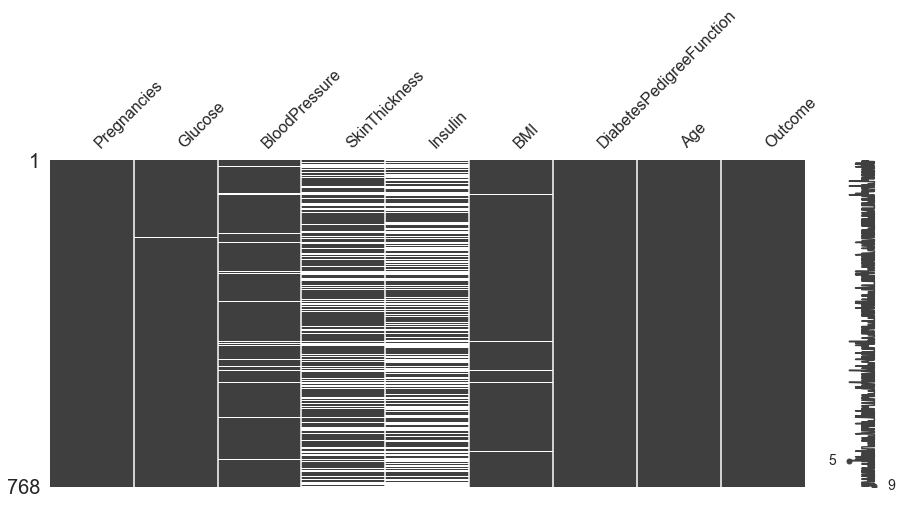

In [12]:
# Visualisation des données manquantes par un graphique
msno.matrix(df_diabete, figsize = (15, 6))

# Méthodes de nettoyage des données
- Drop
- Imputation

## Drop des données
On va droper l'ensemble des Nan de notre jeu de données

In [13]:
diabete_drop = df_diabete.copy()
diabete_drop.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [14]:
# On supprime les valeurs nan avec la function dropna
# axis : 0 = ligne, 1 = colonne
# how : prend la valeur de chaîne de deux sortes seulement (' n’importe quel' ou 'all'). 'any' baisse la ligne/colonne si n’importe quelle valeur est Null et 'all' ne baisse que si les valeurs ALL sont nulles.
# inplace True : vire les données du df
diabete_drop.dropna(axis=0, how='any', inplace = True)
diabete_drop.Outcome.value_counts()

0    262
1    130
Name: Outcome, dtype: int64

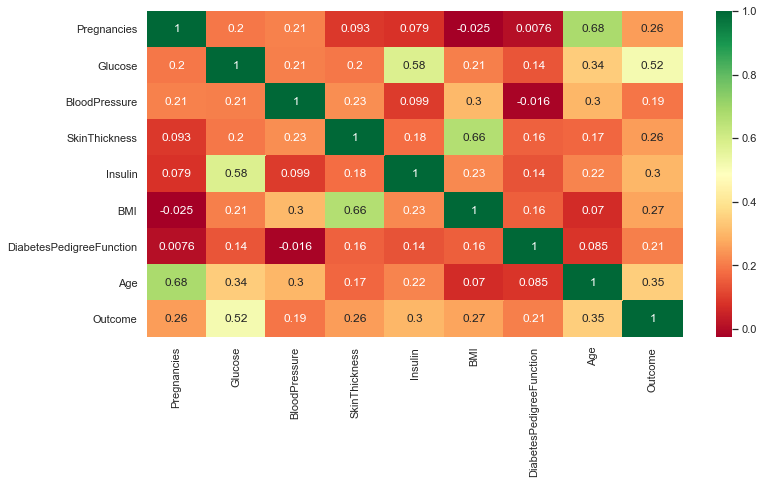

In [15]:
# Obtenir les corrélations entre les features mais surtout avec la target
plt.figure(figsize=(12,6))
sns.heatmap(diabete_drop.corr(),annot=True,cmap="RdYlGn")

0    262
1    130
Name: Outcome, dtype: int64


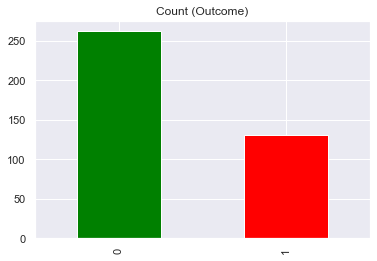

In [16]:
# Répartition des données, non diabétique(0) ou diabétique(1), sur un histogramme
diabete_drop['Outcome'].value_counts().plot(kind='bar', title='Count (Outcome)', color = ['Green', 'Red'])
print(diabete_drop.Outcome.value_counts())

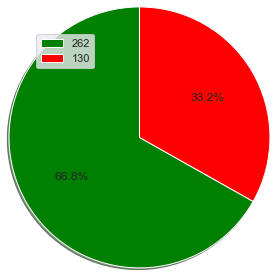

In [17]:
# Répartition des données, non diabétique(0) ou diabétique(1), en pourcentage sur un camenbert
plt.pie(x=diabete_drop['Outcome'].value_counts(), autopct="%1.1f%%", shadow=True,
        startangle=90, radius=1.5, colors = ['Green', 'Red'])
plt.legend(labels=diabete_drop['Outcome'].value_counts())
plt.show()

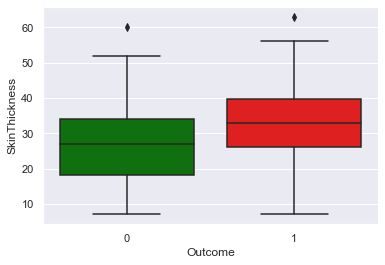

In [18]:
# Classification de la colonne DiabetesPedigreeFunction en fonction de la classe 'Pregnancies', sur une boîte à moustache
sns.boxplot(x="Outcome", y="SkinThickness", data=diabete_drop, palette = ('Green', 'Red'))

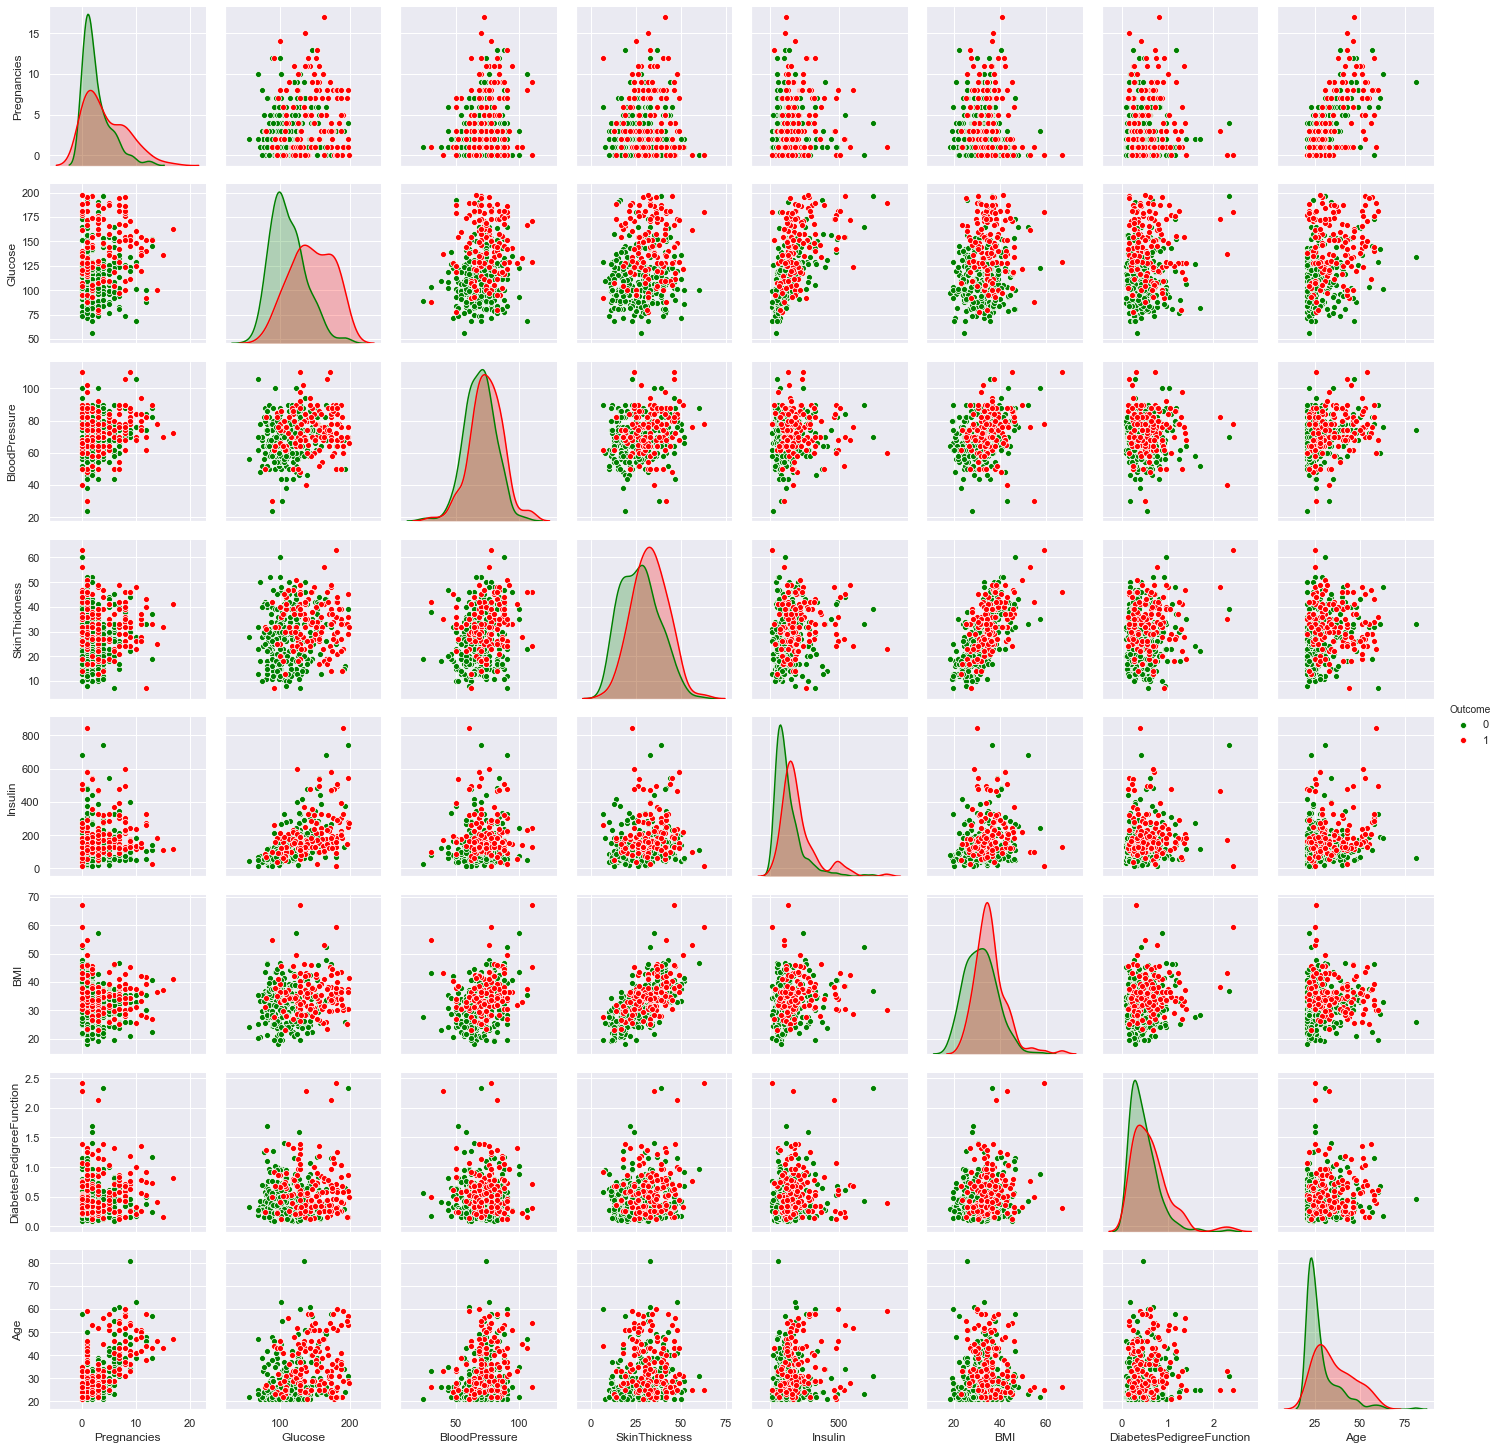

In [19]:
# On visualise nos différentes corrélation possible
sns.pairplot(diabete_drop, hue = 'Outcome', palette = ('Green', 'Red'))

On peut voir que nous avons des corrélations entre Glucose et Insulin, SkinThickness et BMI. Et d'autres pas franchement flagrante.

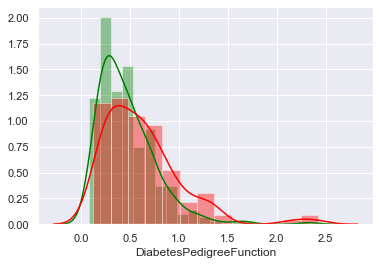

In [20]:
sns.distplot(diabete_drop['DiabetesPedigreeFunction'].loc[diabete_drop['Outcome'] == 0], color = 'Green')
sns.distplot(diabete_drop['DiabetesPedigreeFunction'].loc[diabete_drop['Outcome'] == 1], color = 'Red')

### Equilibrage des données : SMOTE

In [21]:
# Utilisation smote pour augmenter la classe minoritaire.
sm = SMOTE(random_state=42)
X_smotedrop, y_smotedrop = sm.fit_resample(diabete_drop[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']],
                                           diabete_drop['Outcome'])
y_smotedrop.value_counts()

1    262
0    262
Name: Outcome, dtype: int64

### Normalisation des données

In [22]:
# Mettre à l'échelle = normaliser :
Scaledrop = pd.DataFrame(scale(X_smotedrop), columns = X_smotedrop.columns)
Drop = Scaledrop

## Imputation des données
On va imputer l'ensemble des Nan de notre jeu de données

Dans l'optique d'appliquer des imputations, on commence par séparer le jeu de données en 2:  
- 1 jeu contenant les valeurs pour les personnes diabétiques (1)
- 1 jeu contenant les valeurs pour les personnes non diabétiques (0)

### Jeu de données pour les diabétiques

In [23]:
# DF_D = Diabétiques
# .loc permet de "simuler" des requêtes SQL avec WHERE

DF_D = df_diabete.loc[df_diabete.Outcome == 1]
DF_D.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1


In [24]:
# On somme les valeurs Nan dans chacune des colonnes
print(DF_D.isnull().sum())

Pregnancies                   0
Glucose                       2
BloodPressure                16
SkinThickness                88
Insulin                     138
BMI                           2
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [25]:
DF_D[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,266.000000,252.000000,180.000000,130.000000,266.000000
mean,142.319549,75.321429,33.000000,206.846154,35.406767
std,29.599199,12.299866,10.327595,132.699898,6.614982
min,78.000000,30.000000,7.000000,14.000000,22.900000
25%,119.000000,68.000000,27.000000,127.500000,30.900000
50%,140.000000,74.500000,32.000000,169.500000,34.300000
75%,167.000000,84.000000,39.000000,239.250000,38.925000
max,199.000000,114.000000,99.000000,846.000000,67.100000


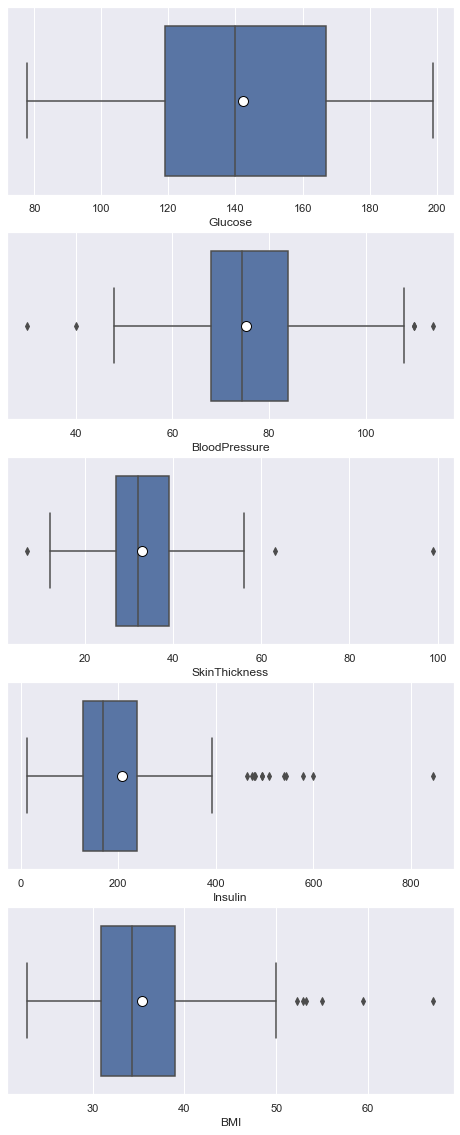

In [26]:
# On fait des boxplots pour choisir de quelles manières on va appliquer l'imputation
# On observe partiulièrement la moyenne et la médiane

plt.figure(figsize=(8, 20))
plt.subplot(5, 1, 1)
sns.boxplot(x=DF_D["Glucose"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 2)
sns.boxplot(x=DF_D["BloodPressure"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 3)
sns.boxplot(x=DF_D["SkinThickness"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 4)
sns.boxplot(x=DF_D["Insulin"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 5)
sns.boxplot(x=DF_D["BMI"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.show()

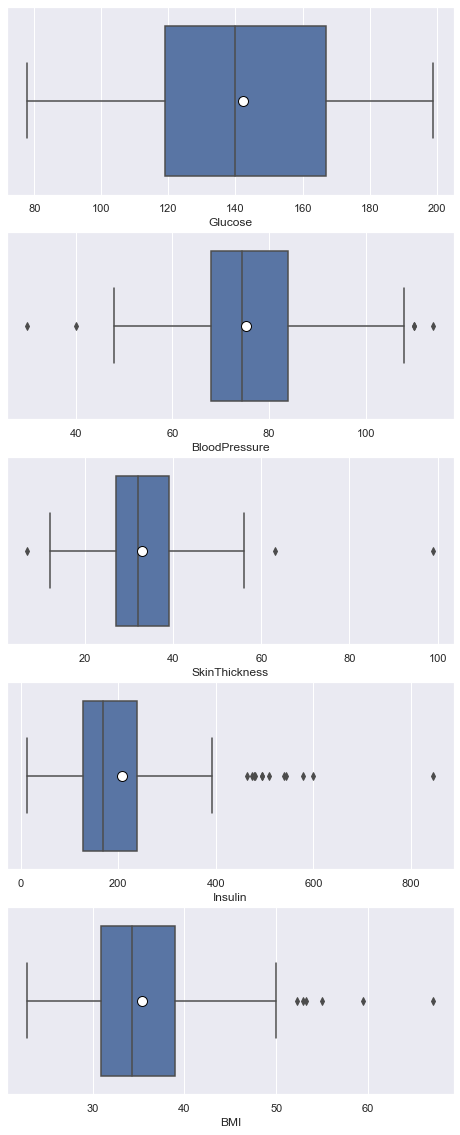

In [27]:
# Version optimisé avec une boucle

# On stock dans une variable la liste des colonnes qui nous intéresse
var = (1,2,3,4,5)
# On stock dans une varible le numéro de figure à laquelle commence la création du 1er boxplot
n = 1
# On définit la taille de chaque figure
plt.figure(figsize=(8,20))
# Création de la boucle
# i = chacune des itérations qui vont être opéré dans var

for i in var:
    # la position de chaque figure ou n changera à chacune des itérations
    plt.subplot(5,1,n)
    # .iloc[:,i] = chacune des lignes sera parcouru dans chaque colonne contenu dans var 
    # et ce à chaque itération
    sns.boxplot(x=DF_D.iloc[:,i], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
    # le numéro de la figure augmentera jusqu'à ce que chacune des colonnes (var) auront été parcourues
    n = n+1

### Jeu de données pour les non diabétiques

In [28]:
# DF_ND = Non diabétiques
# .loc permet de "simuler" des requêtes SQL avec WHERE

DF_ND = df_diabete.loc[df_diabete.Outcome == 0]
DF_ND.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
5,5,116.0,74.0,NaN,NaN,25.6,0.201,30,0
7,10,115.0,NaN,NaN,NaN,35.3,0.134,29,0
10,4,110.0,92.0,NaN,NaN,37.6,0.191,30,0


In [29]:
print(DF_ND.isnull().sum())

Pregnancies                   0
Glucose                       3
BloodPressure                19
SkinThickness               139
Insulin                     236
BMI                           9
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [30]:
DF_ND[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].describe()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,497.000000,481.000000,361.000000,264.000000,491.000000
mean,110.643863,70.877339,27.235457,130.287879,30.859674
std,24.776906,12.161223,10.026491,102.482237,6.560737
min,44.000000,24.000000,7.000000,15.000000,18.200000
25%,93.000000,62.000000,19.000000,66.000000,25.600000
50%,107.000000,70.000000,27.000000,102.500000,30.100000
75%,125.000000,78.000000,33.000000,161.250000,35.300000
max,197.000000,122.000000,60.000000,744.000000,57.300000


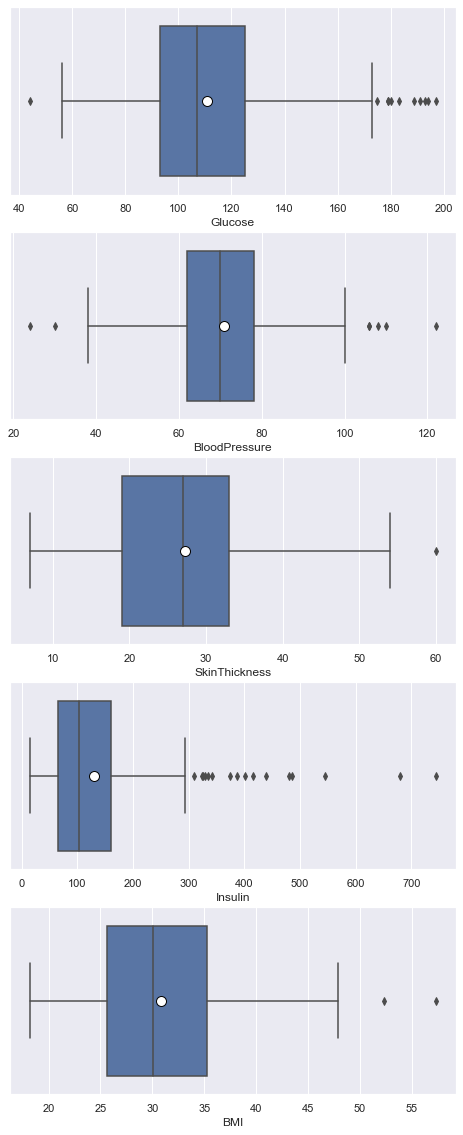

In [31]:
plt.figure(figsize=(8, 20))
plt.subplot(5, 1, 1)
sns.boxplot(x=DF_ND["Glucose"], showmeans=True,  meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 2)
sns.boxplot(x=DF_ND["BloodPressure"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 3)
sns.boxplot(x=DF_ND["SkinThickness"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 4)
sns.boxplot(x=DF_ND["Insulin"], showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.subplot(5, 1, 5)
sns.boxplot(x=DF_ND["BMI"], showmeans=True,  meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.show()

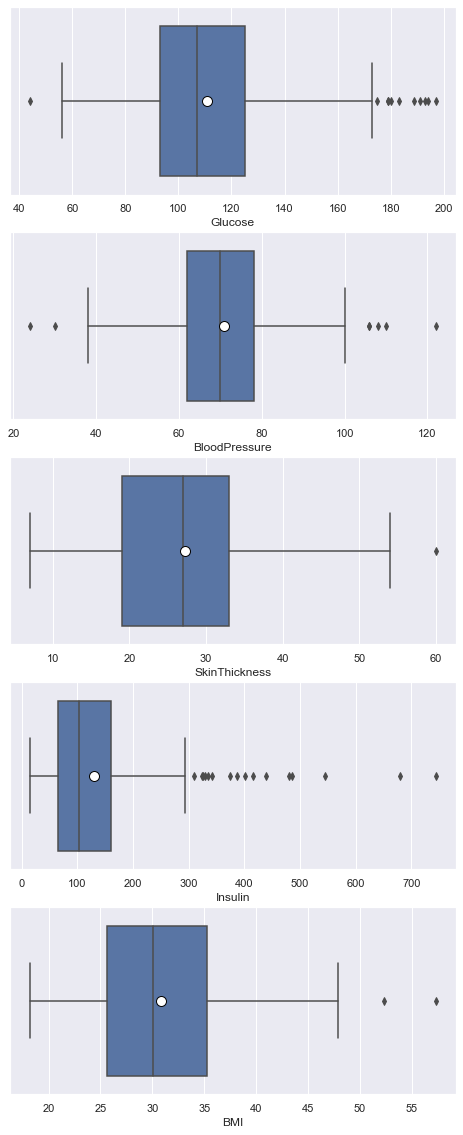

In [32]:
var= (1,2,3,4,5)
n = 1

plt.figure(figsize=(8,20))

for i in var:
    plt.subplot(5, 1, n)
    sns.boxplot(x=DF_ND.iloc[:,i], showmeans=True,  meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
    n=n+1

### Imputation par la médiane

Imputation des données pour les personnes diabétiques

In [33]:
DF_D_median = DF_D.copy()

In [34]:
median = DF_D_median[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].median()
median

Glucose          140.0
BloodPressure     74.5
SkinThickness     32.0
Insulin          169.5
BMI               34.3
dtype: float64

In [35]:
var=(1,2,3,4,5)

for i in var:
    DF_D_median.iloc[:,i].fillna(DF_D_median.iloc[:,i].median(), inplace=True)

In [36]:
DF_D_median.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Imputation des données pour les personnes non diabétiques

In [37]:
DF_ND_median = DF_ND.copy()

In [38]:
median = DF_D_median[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].median()
print(median)
var=(1,2,3,4,5)

for i in var:
    DF_D_median.iloc[:,i].fillna(DF_D_median.iloc[:,i].median(), inplace=True)
print(DF_D_median.isnull().sum())

Glucose          140.0
BloodPressure     74.5
SkinThickness     32.0
Insulin          169.5
BMI               34.3
dtype: float64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### Imputation par la moyenne

Imputation des données pour les personnes diabétiques

In [39]:
DF_D_mean = DF_D.copy()

In [40]:
mean = DF_D_mean[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].mean()
mean

Glucose          142.319549
BloodPressure     75.321429
SkinThickness     33.000000
Insulin          206.846154
BMI               35.406767
dtype: float64

In [41]:
var=(1,2,3,4,5)

for i in var:
    DF_D_mean.iloc[:,i].fillna(DF_D_mean.iloc[:,i].mean(), inplace=True)

In [42]:
DF_D_mean.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Imputation des données pour les personnes non diabétiques

In [43]:
DF_ND_mean = DF_ND.copy()

In [44]:
mean = DF_ND_mean[["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]].mean()
print(mean)
var=(1,2,3,4,5)

for i in var:
    DF_ND_mean.iloc[:,i].fillna(DF_ND_mean.iloc[:,i].mean(), inplace=True)
print(DF_ND_mean.isnull().sum())

Glucose          110.643863
BloodPressure     70.877339
SkinThickness     27.235457
Insulin          130.287879
BMI               30.859674
dtype: float64
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### Imputation des voisins les plus proches
https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

Imputation des données pour les personnes diabétiques

In [45]:
X = DF_D.copy()

In [46]:
X.isnull().sum()

Pregnancies                   0
Glucose                       2
BloodPressure                16
SkinThickness                88
Insulin                     138
BMI                           2
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               268 non-null    int64  
 1   Glucose                   266 non-null    float64
 2   BloodPressure             252 non-null    float64
 3   SkinThickness             180 non-null    float64
 4   Insulin                   130 non-null    float64
 5   BMI                       266 non-null    float64
 6   DiabetesPedigreeFunction  268 non-null    float64
 7   Age                       268 non-null    int64  
 8   Outcome                   268 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 20.9 KB


In [48]:
# On impute les données avec la méthode KNN

# X contient les données
X
# n_neighbors=2 : Imputation avec les 2 voisins les plus proches, 
# weights="uniform" : le poids est uniforme 
# copy=False : les données sont changées à la source
imputer = KNNImputer(n_neighbors=2, weights="uniform", copy=False)
# ajuste les données et les transforme en créant un X = X.iloc[:,0:8], et un y = X.iloc[8]
imp = imputer.fit_transform(X.iloc[:,0:8])

In [49]:
#On stock le résultat de l'imputation (imp), qu'on transforme en Dataframe dans la variable DF_D_KNN
DF_D_KNN = pd.DataFrame(imp, columns = X.iloc[:,0:8].columns)
DF_D_KNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               268 non-null    float64
 1   Glucose                   268 non-null    float64
 2   BloodPressure             268 non-null    float64
 3   SkinThickness             268 non-null    float64
 4   Insulin                   268 non-null    float64
 5   BMI                       268 non-null    float64
 6   DiabetesPedigreeFunction  268 non-null    float64
 7   Age                       268 non-null    float64
dtypes: float64(8)
memory usage: 16.9 KB


In [50]:
# On récupère la valeur 1 correspondant au personnes diabétiques

DF_D_KNN['Outcome'] = 1

In [51]:
DF_D_KNN.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [52]:
# On observe les résultats de nos différentes imputations

print("Moyenne DF_D_KNN :\n", DF_D_KNN.mean())
print("Moyenne DF_D_mean :\n",DF_D_mean.mean())
print("Moyenne DF_D_median :\n",DF_D_median.mean())

Moyenne DF_D_KNN :
 Pregnancies                   4.865672
Glucose                     142.326493
BloodPressure                75.022388
SkinThickness                32.791045
Insulin                     198.236940
BMI                          35.403172
DiabetesPedigreeFunction      0.550500
Age                          37.067164
Outcome                       1.000000
dtype: float64
Moyenne DF_D_mean :
 Pregnancies                   4.865672
Glucose                     142.319549
BloodPressure                75.321429
SkinThickness                33.000000
Insulin                     206.846154
BMI                          35.406767
DiabetesPedigreeFunction      0.550500
Age                          37.067164
Outcome                       1.000000
dtype: float64
Moyenne DF_D_median :
 Pregnancies                   4.865672
Glucose                     142.302239
BloodPressure                75.272388
SkinThickness                32.671642
Insulin                     187.615672
BMI      

Imputation des données pour les personnes non diabétiques

In [53]:
X = DF_ND.copy()

In [54]:
X
imputer = KNNImputer(n_neighbors=2, weights="uniform", copy=False)
imp = imputer.fit_transform(X.iloc[:,0:8], X.iloc[8])

In [55]:
DF_ND_KNN = pd.DataFrame(imp, columns = X.iloc[:,0:8].columns)
DF_ND_KNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               500 non-null    float64
 1   Glucose                   500 non-null    float64
 2   BloodPressure             500 non-null    float64
 3   SkinThickness             500 non-null    float64
 4   Insulin                   500 non-null    float64
 5   BMI                       500 non-null    float64
 6   DiabetesPedigreeFunction  500 non-null    float64
 7   Age                       500 non-null    float64
dtypes: float64(8)
memory usage: 31.4 KB


In [56]:
DF_ND_KNN['Outcome'] = 0

In [57]:
print("Moyenne DF_ND_KNN :\n", DF_ND_KNN.mean())
print("Moyenne DF_ND_mean :\n",DF_ND_mean.mean())
print("Moyenne DF_ND_median :\n",DF_ND_median.mean())

Moyenne DF_ND_KNN :
 Pregnancies                   3.298000
Glucose                     110.469000
BloodPressure                70.774000
SkinThickness                27.028000
Insulin                     124.696000
BMI                          30.841600
DiabetesPedigreeFunction      0.429734
Age                          31.190000
Outcome                       0.000000
dtype: float64
Moyenne DF_ND_mean :
 Pregnancies                   3.298000
Glucose                     110.643863
BloodPressure                70.877339
SkinThickness                27.235457
Insulin                     130.287879
BMI                          30.859674
DiabetesPedigreeFunction      0.429734
Age                          31.190000
Outcome                       0.000000
dtype: float64
Moyenne DF_ND_median :
 Pregnancies                   3.298000
Glucose                     110.643863
BloodPressure                70.877339
SkinThickness                27.235457
Insulin                     130.287879
BMI   

## Conclusion des imputations
A la comparaison de nos résultats sur 3 types d'imputations on note que:
- Les features les plus impactées par l'imputation sont SkinThickness et Insulin
- Les moyennes des features sont tirés vers le haut avec l'imputation par la moyenne, vers le bas avec l'imputation par la médiane.
- Les résultats des moyennes des features avec l'imputation par le KNN se situe entre les 2 autres.  
Nous arrêterons donc notre choix sur la méthode du KNN.

### Visualisation du jeu de donnée clean
Les données imputées avec la méthode KNN

On concatène nos 2 dataframes résultants de l'imputation par le KNN = DF_KNN

In [58]:
DF_KNN = pd.concat([DF_D_KNN, DF_ND_KNN])

In [59]:
# On récupère ici le Daframe comprenant les personnes diabétiques et non diabétiques, imputer par KNN.

DF_KNN

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,138.0,33.6,0.627,50.0,1
1,8.0,183.0,64.0,37.5,227.5,23.3,0.672,32.0,1
2,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1
3,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,1
4,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,1
...,...,...,...,...,...,...,...,...,...
495,9.0,89.0,62.0,21.5,36.0,22.5,0.142,33.0,0
496,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,0
497,2.0,122.0,70.0,27.0,147.5,36.8,0.340,27.0,0
498,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,0


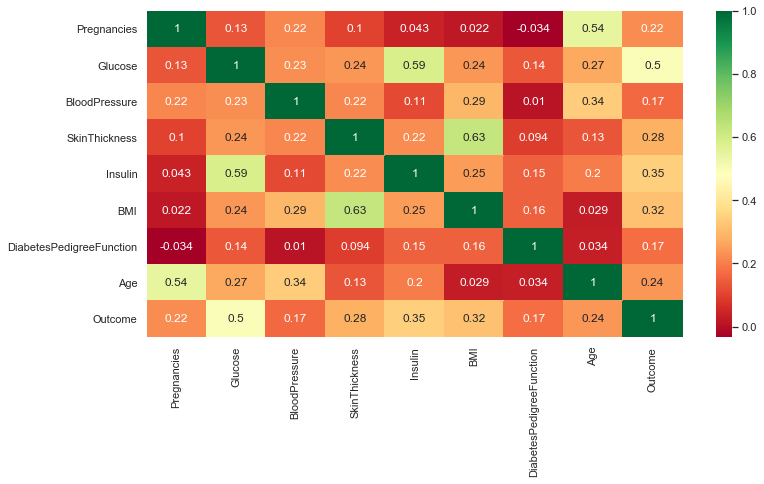

In [60]:
# Obtenir les corrélations entre les features mais surtout avec la target
plt.figure(figsize=(12,6))
sns.heatmap(DF_KNN.corr(),annot=True,cmap="RdYlGn")

In [61]:
# Export du fichier CSV

DF_KNN.to_csv("./DF_KNN.csv", index = True)

In [62]:
print(DF_KNN.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 60.0 KB
None


In [63]:
DF_KNN.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.585938,72.256510,29.039062,150.358724,32.433398,0.471876,33.240885,0.348958
std,3.369578,30.561687,12.279129,9.702943,100.830100,6.899939,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,83.875000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,129.500000,32.150000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,35.000000,185.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


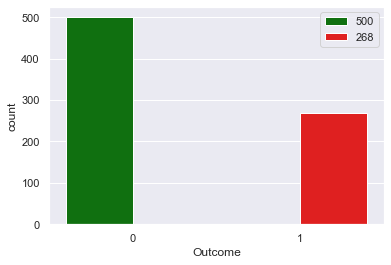

In [64]:
sns.countplot(DF_KNN.Outcome, palette = ('Green', 'Red'), hue = DF_KNN.Outcome)
plt.legend(DF_KNN.Outcome.value_counts())

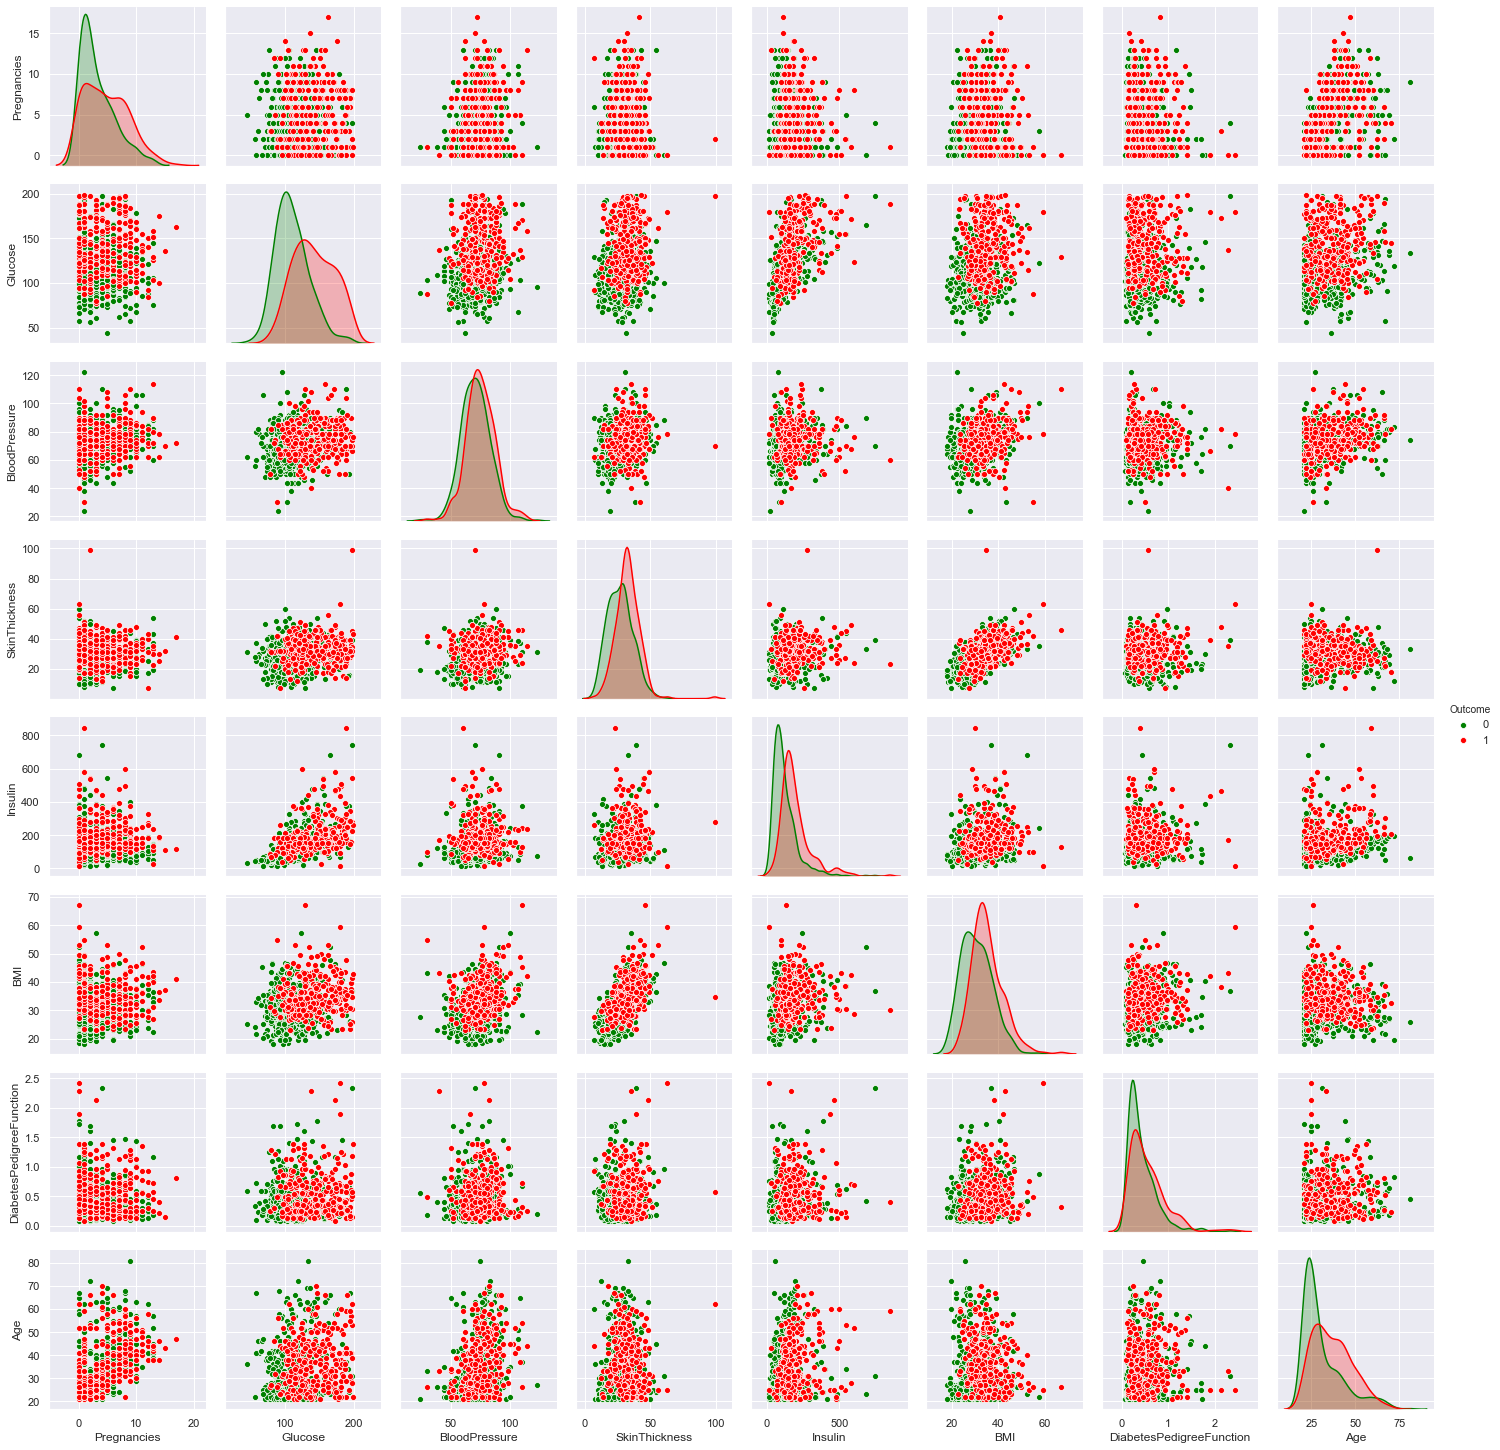

In [65]:
sns.pairplot(DF_KNN, hue = 'Outcome', palette = ('Green', 'Red'))

<Figure size 1152x1440 with 0 Axes>

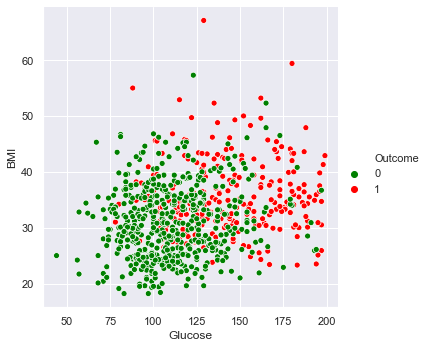

In [66]:
plt.figure(figsize =(16,20))
sns.relplot( x="Glucose", y="BMI", data=DF_KNN, hue ='Outcome', palette = ('Green', 'Red'))

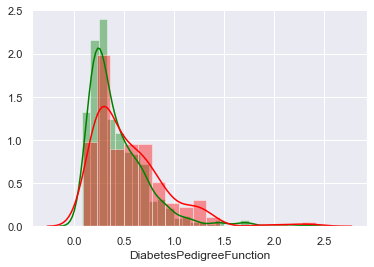

In [67]:
sns.distplot(DF_KNN['DiabetesPedigreeFunction'].loc[DF_KNN['Outcome'] == 0], color = 'Green')
sns.distplot(DF_KNN['DiabetesPedigreeFunction'].loc[DF_KNN['Outcome'] == 1], color = 'Red')

### Equilibrage des données
On a constaté que les 2 catégories contenu par la target Outcome sont déséquilibrées.  
500 = Non diabétiques  
268 = Diabétiques  

Nous allons ré-équilibrer le jeu de données en utilisant la Méthode SMOTE. 
  
Cette méthode est basée sur le principe du KNN et permet de sur-échantilloner la partie du jeu de données au niveau de la catégories contenant le plus d'individu.

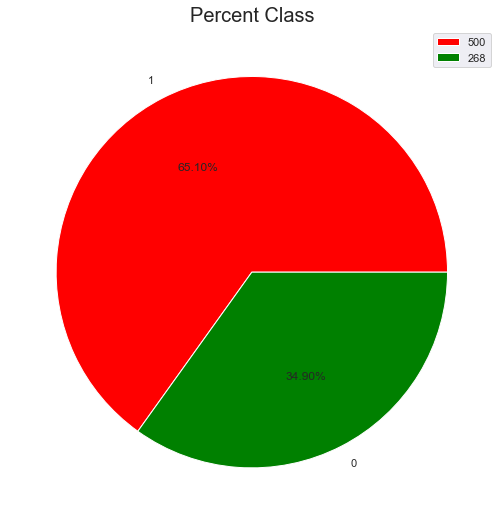

In [68]:
labels = ['1', '0']
size = DF_KNN.Outcome.value_counts()
colors = ['red', 'green']

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.title('Percent Class', fontsize = 20)

plt.legend(DF_KNN.Outcome.value_counts())
plt.show()

In [69]:
DF_KNN.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [70]:
# SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(DF_KNN[['Pregnancies', 'Glucose', 'BloodPressure', 
                                              'SkinThickness','Insulin', 'BMI',
                                             'DiabetesPedigreeFunction', 'Age']], DF_KNN['Outcome'])
y_smote.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

### Partie 1 : ANALYSE EN COMPOSANTES PRINCIPALES
L'ACP permet de concentrer les données des features dans plusieurs nouvelles features appelées Axes  
Elles se basent sur la variance des données brutes ou mise à l'échelle  
Elles permettent de n'utiliser que les variables qui concentrent l'ensemble des données  
=> à partir de 70% on peut estimer que cela est suffisant

In [71]:

# définition de la commande
pca = PCA()
# Sélection des variables quantitatives
dat=X_smote
# réduction
data = pd.DataFrame(scale(dat),columns=dat.columns)
# composantes principales
C = pca.fit(data).transform(data)
resultPCA = pd.DataFrame(C)
resultPCA

,0,1,2,3,4,5,6,7
0,1.081449,-0.787618,0.115435,0.521986,-0.487620,0.157453,0.879624,0.368209
1,0.775498,-0.427599,1.720139,0.079719,-1.046681,-1.060697,0.937501,-1.315225
2,0.436363,3.086130,2.235480,4.997588,-1.267435,0.344560,0.570771,1.362292
3,-2.110056,0.517577,-0.521598,-0.208354,-1.622915,0.456784,-0.114811,0.071501
4,3.097520,0.350604,2.416505,-2.378870,-0.709749,1.685060,0.558397,-0.743450
...,...,...,...,...,...,...,...,...
995,0.330490,-1.021318,-0.497806,-0.332290,-0.781756,-0.492299,0.164779,-0.039569
996,3.143780,-1.304334,-0.616497,-0.217250,1.806360,-0.183606,-0.327119,0.496109
997,1.484561,-0.607290,-0.084218,0.031980,-0.746144,-1.440957,0.066462,0.030976
998,-0.080728,1.367999,1.054156,1.885494,-1.037797,0.256840,0.338766,0.722793


In [72]:
# On voit ici le % de variance expliqué par chacun des axes PCA
# Avec les 2 premiers on atteint quasi 70 %
print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)

# Matrice des coefficients de corrélation linéaire entre les variables initiales et les facteurs
# En colonne les variables initiales et en lignes les axes PCA
print("Composantes principales : ")
pd.DataFrame(pca.components_)

Pourcentage de variance expliquée : 
[0.31243547 0.18979979 0.14612854 0.11697625 0.09000885 0.05501943
 0.04808725 0.04154442]
Composantes principales : 


,0,1,2,3,4,5,6,7
0,0.243695,0.434015,0.358506,0.402476,0.396442,0.409576,0.136755,0.343670
1,-0.595109,0.068259,-0.169251,0.313949,0.143283,0.385646,0.189623,-0.555668
2,-0.090525,0.450971,-0.385726,-0.363902,0.529696,-0.373628,0.292143,0.041209
3,0.162162,-0.244170,-0.014974,0.006066,-0.253997,0.041439,0.917117,0.080554
4,-0.410740,0.113846,0.770458,-0.448441,-0.029066,-0.076124,0.118615,-0.054011
5,-0.474209,-0.536950,-0.029701,0.172670,0.356632,-0.108122,-0.006547,0.563200
6,-0.353078,0.471911,-0.072090,0.383411,-0.534873,-0.348883,0.025348,0.303289
7,-0.183634,0.141424,-0.306814,-0.478611,-0.251181,0.634827,-0.064310,0.390950


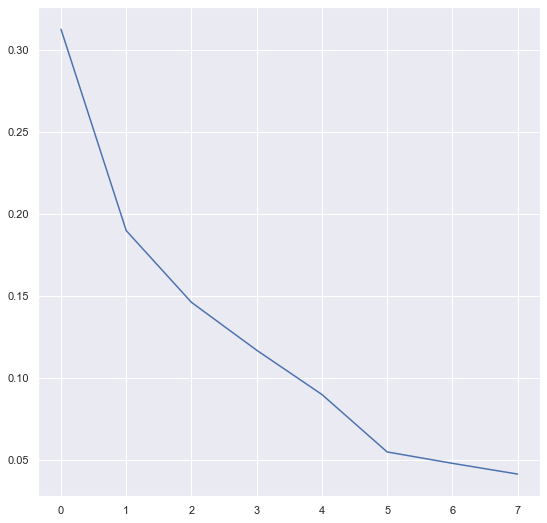

In [73]:
# Eboulis des valeurs propres
# Représentation graphique du taux de variances par axe PCA
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

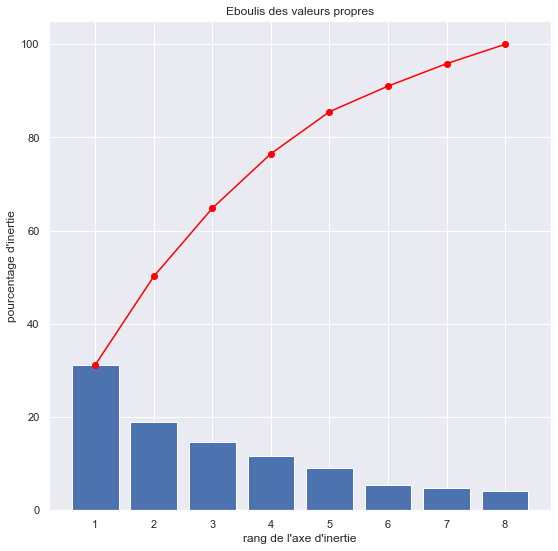

In [74]:
# Fonction OpenClassRoom
# Eboulis des valeurs propres
# Représentation graphique du taux de variances par axe PCA
display_scree_plot(pca)

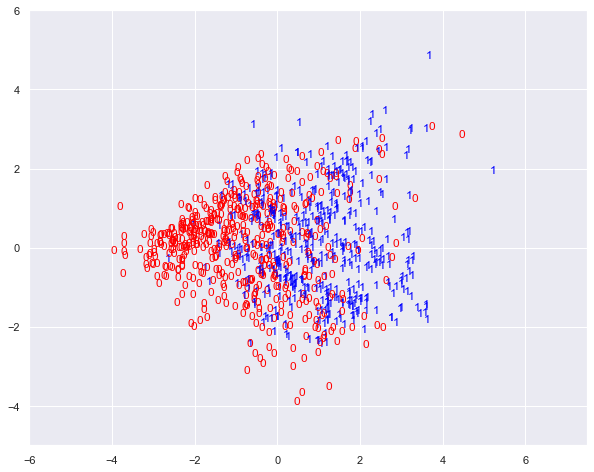

In [75]:
# Projection des individus
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], y_smote):
    color = "red" if nom == 0 else "blue"
    plt.text(i, j, nom, color=color)
plt.axis((-6,7.5,-5,6))  
plt.show()

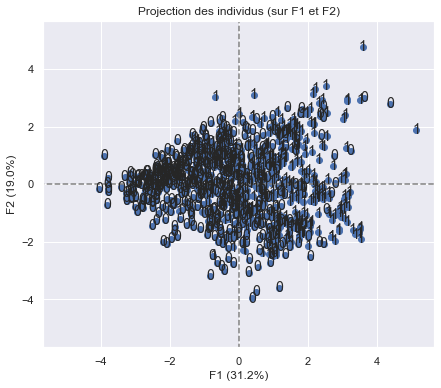

In [76]:
# Fonction OpenClassRoom
# Projection des individus

#X_projected = pca.transform(data)
# names = y_smote
display_factorial_planes(C, 2, pca, [(0,1),(2,3),(4,5)], labels = np.array(y_smote))

plt.show()

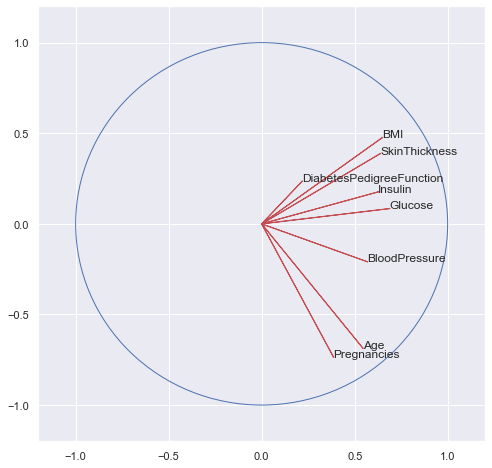

In [77]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

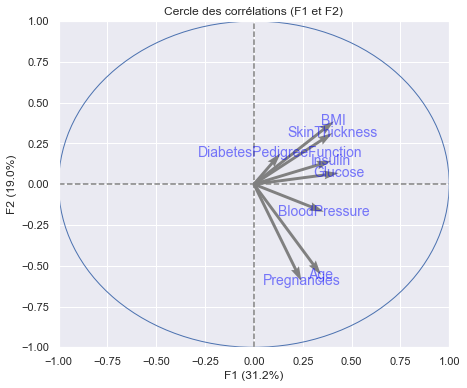

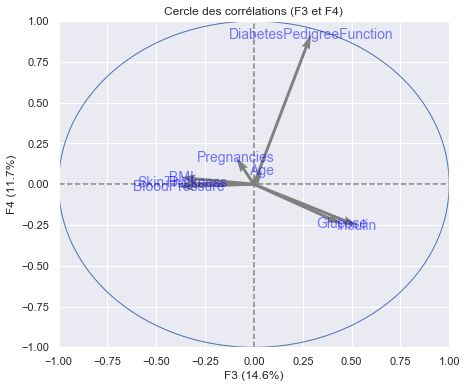

In [78]:
pcs = pca.components_
features = dat.columns
display_circles(pcs, 6, pca, [(0,1),(2,3)], labels = np.array(features))

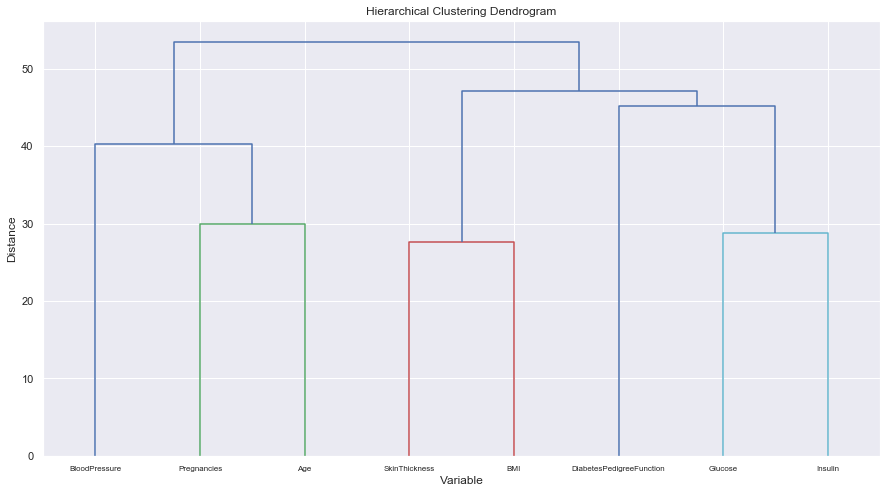

In [79]:
# Stratégie utilisée pour aider à l'interprétation du plan principal 
# lorsque le nombre de variables est important
# Plus particulièrement on voir ici que:
# Axe 0 formé avec l'aide des variables heiht et margin
# Axe 1 avec lenght et diagonale
# NB: on retrouve cela dans l'observation des components_
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data.T, 'ward')
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variable')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size=8.,labels=data.columns)
plt.show()

# Modélisations

## Logistic Regression

### Modélisation avec les données drop
Ici on utilise les données drop, équilibrées et normalisées

In [80]:
Drop
y_smotedrop

0      0
1      1
2      1
3      1
4      1
      ..
519    1
520    1
521    1
522    1
523    1
Name: Outcome, Length: 524, dtype: int64

In [81]:
#On split les données
X_train, X_test, y_train, y_testLRdrop = train_test_split(Drop, y_smotedrop, train_size=0.8, random_state=0)
#Le modèle est stocké dans une variable
modelLR = LogisticRegression(random_state=0)
#On entraine le modèle
resultLRdrop = modelLR.fit(X_train, y_train).predict(X_test)

### Modélisation avec les données bruts
Ici on utilise les données imputée par le KNN sans équilibrage

In [82]:
X = DF_KNN.iloc[:,:8]
y = DF_KNN['Outcome']

LogisticRegression

In [83]:
#On split les données
X_train, X_test, y_train, y_testLRbrut = train_test_split(X, y, train_size=0.8, random_state=0)
#Le modèle est stocké dans une variable
modelLR = LogisticRegression(random_state=0)
#On entraine le modèle
resultLRbrut = modelLR.fit(X_train, y_train).predict(X_test)

C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Modélisation avec les données normalisées
Ici on utilise les données normalisées sans équilibrage

In [84]:
X_scale = pd.DataFrame(scale(DF_KNN.iloc[:,:8]),columns=dat.columns)
y = DF_KNN['Outcome']

LogisticRegression

In [85]:
#On split les données
X_train, X_test, y_train, y_testLRscale = train_test_split(X_scale, y, train_size=0.8, random_state=0)
#Le modèle est stocké dans une variable
modelLR = LogisticRegression(random_state=0)
#On entraine le modèle
modelLR.fit(X_train, y_train)
#On effectue la prédiction du modèle, stockée dans une variable
resultLRscale = modelLR.predict(X_test)

### Modélisation avec les données sur-échantilonnées et nomalisées
Ici on utilise les données équilibrées et normalisée

In [86]:
X = pd.DataFrame(scale(X_smote),columns=dat.columns)
y_smote

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Outcome, Length: 1000, dtype: int64

In [87]:
#On split les données
X_train, X_test, y_train, y_testLRss = train_test_split(X, y_smote, train_size=0.8, random_state=0)
#Le modèle est stocké dans une variable
modelLR = LogisticRegression(random_state=0)
#On entraine le modèle
modelLR.fit(X_train, y_train)
#On effectue la prédiction du modèle, stockée dans une variable
resultLRss = modelLR.predict(X_test)

### Modélisation avec les données sur-échantillonées, normalisées et PCA
Ici on utilise les composantes principales après équilibrage et normalisation

Modélisation avec 3 composantes principales  
Pour rappel:
- les 3 premières composantes représentent 64% de la variance expliquée
- les 4 premières composantes représentent 76% de la variance expliquée

In [88]:
print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_.cumsum())

Pourcentage de variance expliquée : 
[0.31243547 0.50223525 0.64836379 0.76534005 0.8553489  0.91036833
 0.95845558 1.        ]


In [89]:
# Les données en entrées pour les modèles
# X3 = PCA 3 composantes
# X4 = PCA 4 composantes
X3 = resultPCA[[0,1,2]]
X4 = resultPCA[[0,1,2,3]]
y_smote

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: Outcome, Length: 1000, dtype: int64

LogisticRegression

In [90]:
#On split les données
X_train, X_test, y_train, y_testLRpca3 = train_test_split(X3, y_smote, train_size=0.8, random_state=0)
#Le modèle est stocké dans une variable, on entraine
modelLR = LogisticRegression(random_state=0).fit(X_train, y_train)
#On effectue la prédiction du modèle, stockée dans une variable
resultLRpca3 = modelLR.predict(X_test)

In [91]:
X_train, X_test, y_train, y_testLRpca4 = train_test_split(X4, y_smote, train_size=0.8, random_state=0)
modelLR = LogisticRegression(random_state=0).fit(X_train, y_train)
resultLRpca4 = modelLR.predict(X_test)

On compare les résultats des scoring pour le modèle Logistic Regression ayant reçu comme données, 3 composantes principales (PCA 3) et 4 composantes principales (PCA 4)

Logistic Regression :
PCA 3
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       105
           1       0.74      0.75      0.74        95

    accuracy                           0.76       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.76      0.76      0.76       200

____________________________________________________________________________________
PCA 4
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       105
           1       0.75      0.76      0.75        95

    accuracy                           0.77       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.77      0.77      0.77       200



Text(0.5, 1, 'PCA 4')

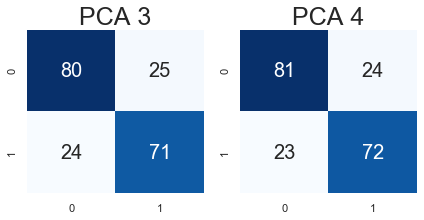

In [92]:
target_names = ['0','1']

print("Logistic Regression :")
print("PCA 3")
print(classification_report(y_testLRpca3, resultLRpca3, target_names=target_names))
print("____________________________________________________________________________________")
print("PCA 4")
print(classification_report(y_testLRpca4, resultLRpca4, target_names=target_names))

plt.figure(figsize=(7, 3))
# sns.set(font_scale = 2)
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_testLRpca3, resultLRpca3),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("PCA 3", fontsize=25)
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_testLRpca4, resultLRpca4),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("PCA 4", fontsize=25)

### On continue avec 3 composantes principales comme les résultats avec 4 composantes ne sont pas significativement supérieurs.

# Analyse et conclusion
Ici on compare les scoring de nos modèles de Regression Logisitic, implémenté par des jeux de données différents :
- Données Bruts
- Données normalisées
- Données nettoyé (drop), sur-échantillonées, normalisées et PCA.3
- Données imputées, sur-échantillonées, normalisées et PCA.3


Logistic Regression :
Données drop
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        56
           1       0.65      0.65      0.65        49

    accuracy                           0.68       105
   macro avg       0.67      0.67      0.67       105
weighted avg       0.68      0.68      0.68       105

____________________________________________________________________________________
Données Bruts
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        98
           1       0.73      0.57      0.64        56

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154

____________________________________________________________________________________
Données normalisées
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        9

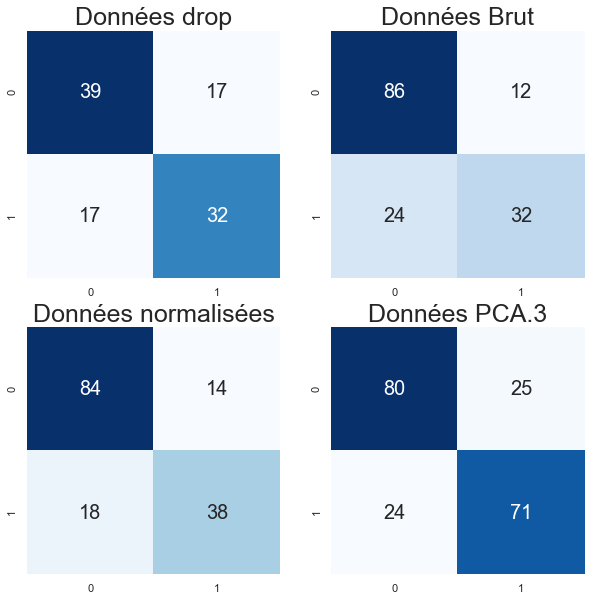

In [93]:
target_names = ['0','1']

print("Logistic Regression :")
print("Données drop")
print(classification_report(y_testLRdrop, resultLRdrop, target_names=target_names))
print("____________________________________________________________________________________")
print("Données Bruts")
print(classification_report(y_testLRbrut, resultLRbrut, target_names=target_names))
print("____________________________________________________________________________________")
print("Données normalisées")
print(classification_report(y_testLRscale, resultLRscale, target_names=target_names))
print("____________________________________________________________________________________")
print("Données sur-échantillonées, normalisées et PCA.3")
print(classification_report(y_testLRpca3, resultLRpca3, target_names=target_names))

plt.figure(figsize=(10, 10))
# sns.set(font_scale = 2)
plt.subplot(2,2,1)
sns.heatmap(confusion_matrix(y_testLRdrop, resultLRdrop),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("Données drop", fontsize=25)
plt.subplot(2,2,2)
sns.heatmap(confusion_matrix(y_testLRbrut, resultLRbrut),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("Données Brut", fontsize=25)
plt.subplot(2,2,3)
sns.heatmap(confusion_matrix(y_testLRscale, resultLRscale),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("Données normalisées", fontsize=25)
plt.subplot(2,2,4)
plt.title("Données PCA.3", fontsize=25)
sns.heatmap(confusion_matrix(y_testLRpca3, resultLRpca3),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})

## Conclusion
### Comparaison des scoring pour les modèles LogsiticRegression
On note que le modèle avec le meilleur score est celui entrainé avec les données normalisées.

# Modélisations avec d'autres modèles
- DecisionTreeClassifier
- RandomForest
- XGboost

In [94]:
X_scale = pd.DataFrame(scale(DF_KNN.iloc[:,:8]),columns=dat.columns)
y = DF_KNN['Outcome']

DecisionTreeClassifier

In [95]:
#On split les données
X_train, X_test, y_train, y_testDTscale = train_test_split(X_scale, y, train_size=0.8, random_state=0)

modelDT = DecisionTreeClassifier().fit(X_train, y_train)
resultDTscale = modelDT.predict(X_test)

RandomForestClassifier données normalisées

In [96]:
#On split les données
X_train, X_test, y_train, y_testRFscale = train_test_split(X_scale, y, train_size=0.8, random_state=0)

modelRF = RandomForestClassifier().fit(X_train, y_train)
resultRFscale = modelRF.predict(X_test)

XGBClassifier données normalisées

In [97]:
#On split les données
X_train, X_test, y_train, y_testXGBscale = train_test_split(X_scale, y, train_size=0.8, random_state=0)

modelXGB = XGBClassifier().fit(X_train, y_train)
resultXGBscale = modelXGB.predict(X_test)

Données normalisées :
Decision Tree
              precision    recall  f1-score   support

           0       0.80      0.71      0.76        98
           1       0.58      0.70      0.63        56

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.72      0.71      0.71       154

____________________________________________________________________________________
Random Forest
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        98
           1       0.69      0.77      0.73        56

    accuracy                           0.79       154
   macro avg       0.78      0.79      0.78       154
weighted avg       0.80      0.79      0.79       154

____________________________________________________________________________________
XG Boost
              precision    recall  f1-score   support

           0       0.85      0.70      0.77        98
        

Text(0.5, 1, 'XG Boost')

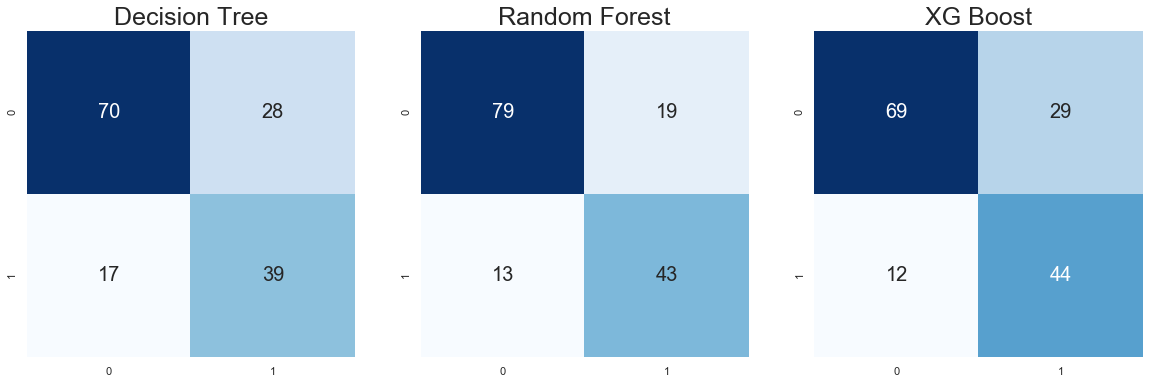

In [98]:
target_names = ['0','1']

print("Données normalisées :")
print("Decision Tree")
print(classification_report(y_testDTscale, resultDTscale, target_names=target_names))
print("____________________________________________________________________________________")
print("Random Forest")
print(classification_report(y_testRFscale, resultRFscale, target_names=target_names))
print("____________________________________________________________________________________")
print("XG Boost")
print(classification_report(y_testXGBscale, resultXGBscale, target_names=target_names))

plt.figure(figsize=(20, 6))
# sns.set(font_scale = 2)
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_testDTscale, resultDTscale),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("Decision Tree", fontsize=25)
plt.subplot(1,3,2)
sns.heatmap(confusion_matrix(y_testRFscale, resultRFscale),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("Random Forest", fontsize=25)
plt.subplot(1,3,3)
sns.heatmap(confusion_matrix(y_testXGBscale, resultXGBscale),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("XG Boost", fontsize=25)


Feature importance scores [0.06874912 0.28325444 0.35481432 0.46271473 0.64807199 0.7844983
 0.88827815 1.        ]


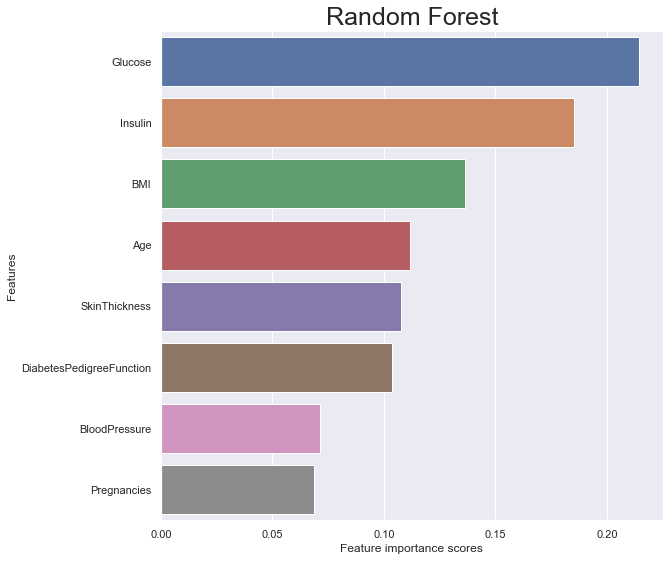

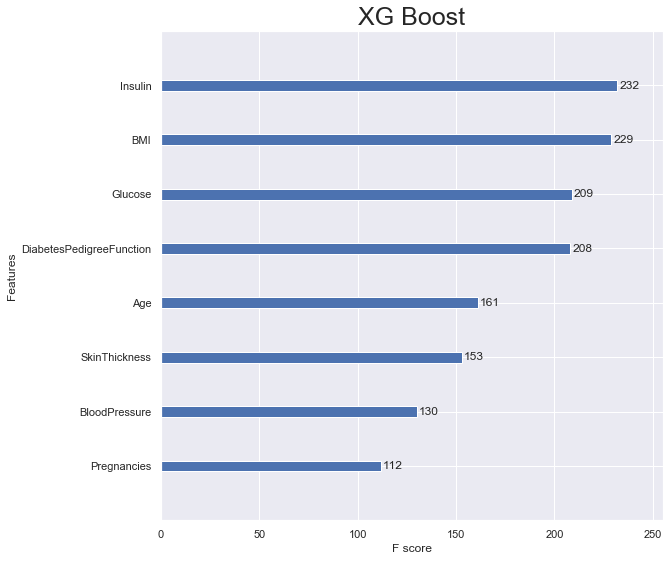

In [99]:
#plt.subplot(1,2,1)
print("Feature importance scores", modelRF.feature_importances_.cumsum())
#plot des scores d'importance
feature_imp = pd.Series(modelRF.feature_importances_, index=X_scale.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel("Feature importance scores")
plt.ylabel("Features")
plt.title("Random Forest", fontsize=25)

xgb.plot_importance(modelXGB)
plt.title("XG Boost", fontsize=25)
plt.show()

### Données PCA 3

DecisionTreeClassifier

In [100]:
X_train, X_test, y_train, y_testDT = train_test_split(X3, y_smote, train_size=0.8)

modelDT = DecisionTreeClassifier().fit(X_train, y_train)
resultDT = modelDT.predict(X_test)


RandomForestClassifier

In [101]:
X_train, X_test, y_train, y_testRF = train_test_split(X3, y_smote, train_size=0.8)

modelRF = RandomForestClassifier().fit(X_train, y_train)
resultRF = modelRF.predict(X_test)

XGBClassifier

In [102]:
X_train, X_test, y_train, y_testXGB = train_test_split(X3, y_smote, train_size=0.8)

modelXGB = XGBClassifier().fit(X_train, y_train)
resultXGB = modelXGB.predict(X_test)

Données PCA 3 :
Decision Tree
              precision    recall  f1-score   support

           0       0.72      0.75      0.74       102
           1       0.73      0.69      0.71        98

    accuracy                           0.73       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200

____________________________________________________________________________________
Random Forest
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       102
           1       0.82      0.83      0.82        98

    accuracy                           0.82       200
   macro avg       0.82      0.83      0.82       200
weighted avg       0.83      0.82      0.83       200

____________________________________________________________________________________
XG Boost
              precision    recall  f1-score   support

           0       0.77      0.80      0.78        91
           1  

Text(0.5, 1, 'XG Boost')

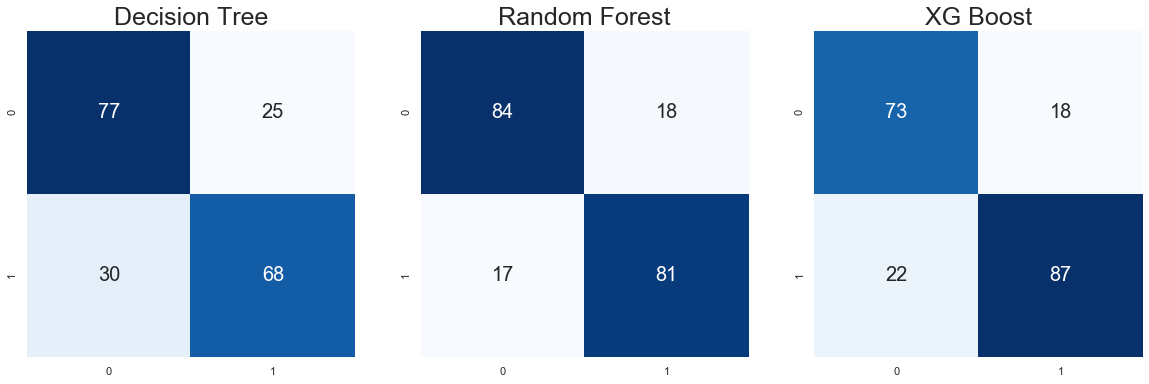

In [103]:
print("Données PCA 3 :")
print("Decision Tree")
print(classification_report(y_testDT, resultDT, target_names=target_names))
print("____________________________________________________________________________________")
print("Random Forest")
print(classification_report(y_testRF, resultRF, target_names=target_names))
print("____________________________________________________________________________________")
print("XG Boost")
print(classification_report(y_testXGB, resultXGB, target_names=target_names))

plt.figure(figsize=(20, 6))
# sns.set(font_scale = 2)
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_testDT, resultDT),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("Decision Tree", fontsize=25)
plt.subplot(1,3,2)
sns.heatmap(confusion_matrix(y_testRF, resultRF),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("Random Forest", fontsize=25)
plt.subplot(1,3,3)
sns.heatmap(confusion_matrix(y_testXGB, resultXGB),annot=True,cmap="Blues", cbar=False, annot_kws={'size':20})
plt.title("XG Boost", fontsize=25)


Feature importance scores : [0.51422465 0.23536236 0.25041298]


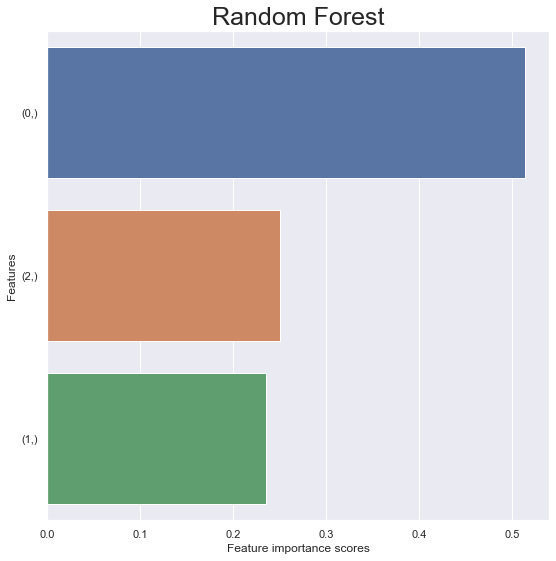

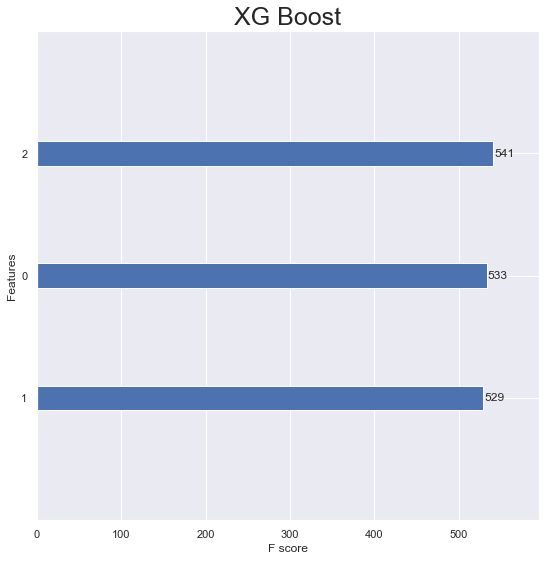

In [104]:
print("Feature importance scores :", modelRF.feature_importances_)
#plot des scores d'importance
feature_imp = pd.Series(modelRF.feature_importances_, index=[[0, 1, 2]]).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Random Forest", fontsize=25)
plt.xlabel("Feature importance scores")
plt.ylabel("Features")
plt.show()

# On visualise le classements des features importances du modèle
xgb.plot_importance(modelXGB)
plt.title("XG Boost", fontsize=25)
plt.show()